# 卷积神经网络

## 卷积层和池化层的实现

### 卷积层的实现

In [7]:
import numpy as np
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)
x2 = np.random.rand(10, 3, 7, 7) # 10个数据
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


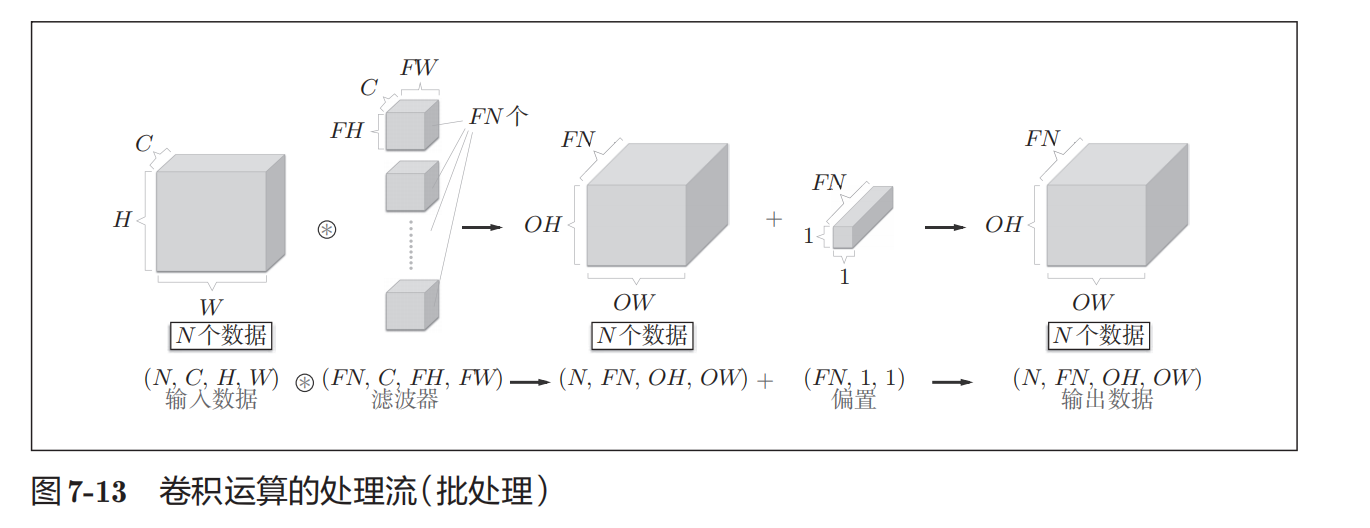[](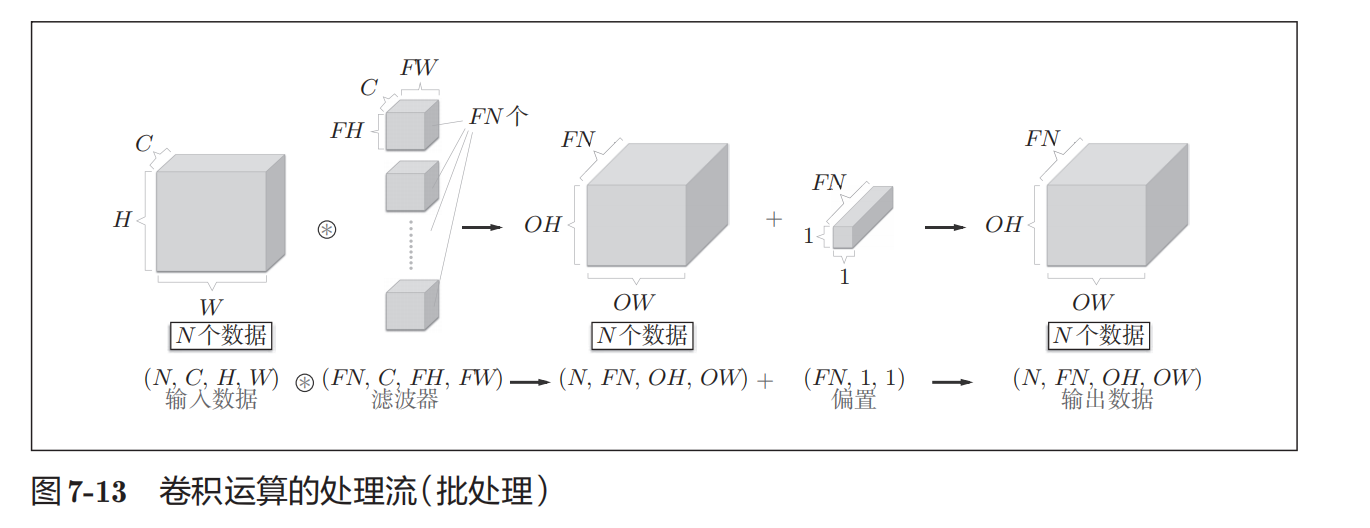)

In [8]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W  # 卷积核权重，形状为 (FN, C, FH, FW)
        self.b = b  # 偏置，形状为 (FN,)
        self.stride = stride  # 步幅
        self.pad = pad  # 填充

    def forward(self, x):
        FN, C, FH, FW = self.W.shape  # 卷积核的形状
        N, C, H, W = x.shape  # 输入数据的形状

        # 计算输出的高度和宽度
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        # 使用 im2col 函数将输入数据展开
        col = im2col(x, FH, FW, self.stride, self.pad)

        # 将卷积核展开为二维矩阵，并转置
        col_W = self.W.reshape(FN, -1).T  # 形状变为 (C * FH * FW, FN) -- -1自动推导

        # 进行矩阵乘法并加上偏置
        out = np.dot(col, col_W) + self.b

        # 将输出重塑并转置，使其形状变为 (N, FN, out_h, out_w)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### 池化层的实现

In [10]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # 展开(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        # 最大值(2)
        out = np.max(col, axis=1)
        # 转换(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## CNN的实现

In [11]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
        conv_param={'filter_num':30, 'filter_size':5,
        'pad':0, 'stride':1},
        hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std *  np.random.randn(filter_num, input_dim[0],
        filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
        self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = softmaxwithloss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # 设定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        return grads